In [1]:
# system level
import sys
import json

# arrays
import numpy as np
from numpy import random

# keras
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import model_from_json
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.callbacks import EarlyStopping


# sklearn (for machine learning)
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# plotting
from matplotlib import pyplot as plt
import pylab as pl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

% matplotlib inline


Using TensorFlow backend.
UsageError: Line magic function `%` not found.


In [ ]:
# utility plots
def remove_tick_labels(axis):
    """Remove tick labels."""
    axis.set_xticklabels([])
    axis.set_yticklabels([])

    for tl in axis.xaxis.get_major_ticks():
        tl.tick1On = tl.tick2On = False
    for tl in axis.yaxis.get_major_ticks():
        tl.tick1On = tl.tick2On = False

def make_mosaic(imgs, nrows, ncols, border=1):
    """Make a nice mosaic.

    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols;
    intended for use with activation layer
    """
    # set up data
    nimgs = imgs.shape[0]
    imshape = imgs.shape#[1:]
    print(nimgs, imgs.shape, imshape)

    mosaic = np.ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                           ncols * imshape[1] + (ncols - 1) * border),
                           dtype=np.float32)

    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
#it used to write xrange(nimgs) but it reported an error since I have Python 3    
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols

        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None, norm=None):
    """Image plot."""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    remove_tick_labels(ax)
    im = ax.imshow(data, vmin=vmin, vmax=vmax,
                   #interpolation='nearest',
                   cmap=cmap,
                   norm=norm)
    plt.colorbar(im, cax=cax)

def get_layers(model, data,
                 version_data,
                 ind_layer_in=0,
                 ind_layer_out=0):
    """Recall activation layer information."""
    data_sets = {"train": 0, "test": 1}
    layer_input = model.layers[ind_layer_in].input
    layer_output = K.function([layer_input, K.learning_phase()],
                              [model.layers[ind_layer_out].output])
    layer_outputs = layer_output([data, data_sets[version_data]])[0]

    return layer_outputs    
    
def plot_layer_filter_panel(
                             layer,
                             ind_obj_choice,
                             n_img_y=6,
                             n_img_x=6):
                             
    """Plot: result of a layer; all filters."""
    # style
    #plt.style.use(dir_style + 'deeplensing.mplstyle')
    sns.set_palette("coolwarm", n_colors=6)
    n_colors = 300
    cmap = sns.color_palette("coolwarm", n_colors=n_colors)#, color_codes=True)
    cmap = ListedColormap(cmap)

    layer_object = layer[ind_obj_choice]
    # layer_object = layer_object + np.abs(np.min(layer_object))+1.0
    c1 = np.squeeze(layer_object)

    # plot
    plt.figure(figsize=(12, 12))
    plt.grid(False)
    nice_imshow(plt.gca(), make_mosaic(c1, n_img_x, n_img_y), vmin=-120, vmax=40, cmap=cmap)#, norm=LogNorm())
    return

In [2]:
# ------------------------------------------------------------------------------
# Input variables
# ------------------------------------------------------------------------------

# training variables
# 70:10:20 for training:valid:test
nb_train = 10799
nb_valid = 1542
nb_test = 3085
nb_epoch = 250
nb_classes = 2
batch_size = 32
shuffle = True

# data locations
dir_test = "model/"
file_x_data =  "SB25_RF_68_augmented.npy" # x data (images)
file_y_data =  "SB25_RF_y_68_augmented.npy" # y data (labels)
#file_lens_data = dir_test + "lenspars_set.npy" # lens data (physical parameters of lenses/non-lenses)
f_model = dir_test + "model_25_68_4.json" # model data (architecture)
f_weights = dir_test + "weights_25_68_4.h5" # model data (weights that we fit for)
f_history = dir_test + "history_25_68_4.json"
f_best_weights = dir_test + "best_weights_68_4.h5"

merg_sub = "SB25_RF_merger_notmerger_y_with_subsamples_augmented_68.npy" #file which contains pre and post merger subsample
subid_load = "SB25_RF_merger_notmerger_SUBID_for_subsamples_augmented_68.npy"#file with all suids after augmentation

cc_load = "SB25_RF_augmented_68_cc.npy" #concentration
m20_load = "SB25_RF_augmented_68_m20.npy" #M20

In [3]:
# load data, all filters
x_data = np.load(file_x_data)
y_data = np.load(file_y_data)
y_sub = np.load(merg_sub)
subids = np.load(subid_load)

cc = np.load(cc_load)
m20 = np.load(m20_load)

In [4]:
# ------------------------------------------------------------------------------
# Read in Data
# ------------------------------------------------------------------------------


#every day we shufflin
random.seed(0)
idx = np.random.choice(len(x_data), size=len(x_data), replace=False)
x_data = x_data[idx]
y_data = y_data[idx]
y_sub_data = y_sub[idx]
subids = subids[idx]
cc = cc[idx]
m20 = m20[idx]

# check data sizes
statement =  "#TrainingSamples + #ValidSamples #TestSamples > TotalSamples, exiting!!!"
nb_total = nb_train + nb_test + nb_valid
assert nb_total <= len(x_data), statement

# indices for where to slice the arrays
ind_valid_start = ind_train_end = nb_train
ind_valid_end = ind_test_start = nb_train + nb_valid
ind_test_end = nb_train + nb_valid + nb_test

# slice the image arrays
x_train = x_data[:ind_train_end, :, :, :]
x_valid = x_data[ind_valid_start: ind_valid_end, :, :, :]
x_test = x_data[ind_test_start: ind_test_end, :, :, :]

# slice the label arrays
y_train = y_data[:ind_train_end]
y_valid = y_data[ind_valid_start: ind_valid_end]
y_test = y_data[ind_test_start: ind_test_end]

# slice the subsample arrays
y_sub_train = y_sub_data[:ind_train_end]
y_sub_valid = y_sub_data[ind_valid_start: ind_valid_end]
y_sub_test = y_sub_data[ind_test_start: ind_test_end]

#slice subids
subid_train = subids[:ind_train_end]
subid_valid = subids[ind_valid_start: ind_valid_end]
subid_test = subids[ind_test_start: ind_test_end]

#slice cc
cc_train = cc[:ind_train_end]
cc_valid = cc[ind_valid_start: ind_valid_end]
cc_test = cc[ind_test_start: ind_test_end]


#slice m20
m20_train = m20[:ind_train_end]
m20_valid = m20[ind_valid_start: ind_valid_end]
m20_test = m20[ind_test_start: ind_test_end]

# cast data types
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')


print( "Data dimensions: ")
print( "Input data: ", np.shape(x_data), np.shape(y_data), "and subsample array:", np.shape(y_sub_data))
print( "Training set: ", np.shape(x_train), np.shape(y_train), "and subsample array:", np.shape(y_sub_train))
print( "Validation set: ", np.shape(x_valid), np.shape(y_valid),"and subsample array:", np.shape(y_sub_valid))
print( "Test Set: ", np.shape(x_test), np.shape(y_test), "and subsample array:", np.shape(y_sub_test))

print("Subid input",np.shape(subids),"Subid train:",np.shape(subid_train),"Subid validation:",np.shape(subid_valid),"Subid test:",np.shape(subid_test))

print("Concentration input",np.shape(cc),"CC train:",np.shape(cc_train),"CC validation:",np.shape(cc_valid),"CC test:",np.shape(cc_test))
print("M20 input",np.shape(m20),"M20 train:",np.shape(m20_train),"M20 validation:",np.shape(m20_valid),"M20 test:",np.shape(m20_test))

Data dimensions: 
Input data:  (15426, 2, 75, 75) (15426,) and subsample array: (15426, 3)
Training set:  (10799, 2, 75, 75) (10799,) and subsample array: (10799, 3)
Validation set:  (1542, 2, 75, 75) (1542,) and subsample array: (1542, 3)
Test Set:  (3085, 2, 75, 75) (3085,) and subsample array: (3085, 3)
Subid input (15426,) Subid train: (10799,) Subid validation: (1542,) Subid test: (3085,)
Concentration input (15426,) CC train: (10799,) CC validation: (1542,) CC test: (3085,)
M20 input (15426,) M20 train: (10799,) M20 validation: (1542,) M20 test: (3085,)


In [15]:
# ------------------------------------------------------------------------------
# generate the model architecture
# example: shallow res (enter link to reference)
# Alex: rewritten for Keras 2
# ------------------------------------------------------------------------------

# Define architecture for model
data_shape = np.shape(x_data)
input_shape = (2, 75, 75)
x = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)



c1 = Convolution2D(15, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)


c2 = Convolution2D(30, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)


f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y = Dense(1, activation='sigmoid')(z1)

model = Model(inputs=x, outputs=y)

# Compile Model
optimizer = 'adam'
metrics = ['accuracy']
loss = 'binary_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 75, 75)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 75, 75)         408       
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 75, 75)         300       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 37, 75)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 37, 75)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 37, 15)         10140     
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 37, 15)         60        
__________

In [9]:
# ------------------------------------------------------------------------------
# Train model
# ------------------------------------------------------------------------------
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50),
     ModelCheckpoint(f_best_weights, monitor='val_acc', mode='max', verbose=1, save_best_only=True)]

# Train 
history = model.fit(
                    x_train, y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data=(x_valid, y_valid),                
                    #shuffle=shuffle,
                    verbose=True,
                    callbacks=es
                    )
# Save data
model.save_weights(f_weights, overwrite=True)
open(f_model, 'w').write(model.to_json())

#Saving history for future use

with open(f_history, 'w') as f:
    json.dump(history.history, f)

NameError: name 'model' is not defined

In [33]:
# seraching for examples
for i in range(len(y_test)):
    if (y_test[i] == 1 and pred[i,0] == 0):
        print (i)
        print(y_test[i],pred[i])

19
1.0 [0]
23
1.0 [0]
32
1.0 [0]
38
1.0 [0]
43
1.0 [0]
52
1.0 [0]
61
1.0 [0]
67
1.0 [0]
71
1.0 [0]
79
1.0 [0]
84
1.0 [0]
89
1.0 [0]
99
1.0 [0]
103
1.0 [0]
136
1.0 [0]
140
1.0 [0]
147
1.0 [0]
151
1.0 [0]
152
1.0 [0]
154
1.0 [0]
155
1.0 [0]
157
1.0 [0]
167
1.0 [0]
173
1.0 [0]
178
1.0 [0]
182
1.0 [0]
194
1.0 [0]
196
1.0 [0]
204
1.0 [0]
210
1.0 [0]
212
1.0 [0]
216
1.0 [0]
220
1.0 [0]
224
1.0 [0]
233
1.0 [0]
238
1.0 [0]
241
1.0 [0]
242
1.0 [0]
262
1.0 [0]
264
1.0 [0]
273
1.0 [0]
277
1.0 [0]
278
1.0 [0]
294
1.0 [0]
300
1.0 [0]
311
1.0 [0]
315
1.0 [0]
317
1.0 [0]
325
1.0 [0]
335
1.0 [0]
352
1.0 [0]
373
1.0 [0]
376
1.0 [0]
380
1.0 [0]
388
1.0 [0]
398
1.0 [0]
402
1.0 [0]
403
1.0 [0]
410
1.0 [0]
411
1.0 [0]
414
1.0 [0]
420
1.0 [0]
430
1.0 [0]
436
1.0 [0]
441
1.0 [0]
448
1.0 [0]
455
1.0 [0]
457
1.0 [0]
458
1.0 [0]
462
1.0 [0]
485
1.0 [0]
496
1.0 [0]
510
1.0 [0]
511
1.0 [0]
514
1.0 [0]
524
1.0 [0]
530
1.0 [0]
546
1.0 [0]
554
1.0 [0]
560
1.0 [0]
563
1.0 [0]
568
1.0 [0]
572
1.0 [0]
586
1.0 [0]
612
1

In [36]:
print(prob[87],prob[1370],prob[2053],prob[3007])
print(prob[538],prob[1216],prob[2900],prob[3021])
print(prob[553],prob[1052],prob[2486],prob[3082])
print(prob[462],prob[1530],prob[2246],prob[3075])

[0.848836] [0.9490057] [0.9338967] [0.8792921]
[0.70171213] [0.77129847] [0.8711706] [0.7559978]
[0.1769699] [0.09907871] [0.17832407] [0.10137492]
[0.3309651] [0.14840135] [0.44694716] [0.4682145]


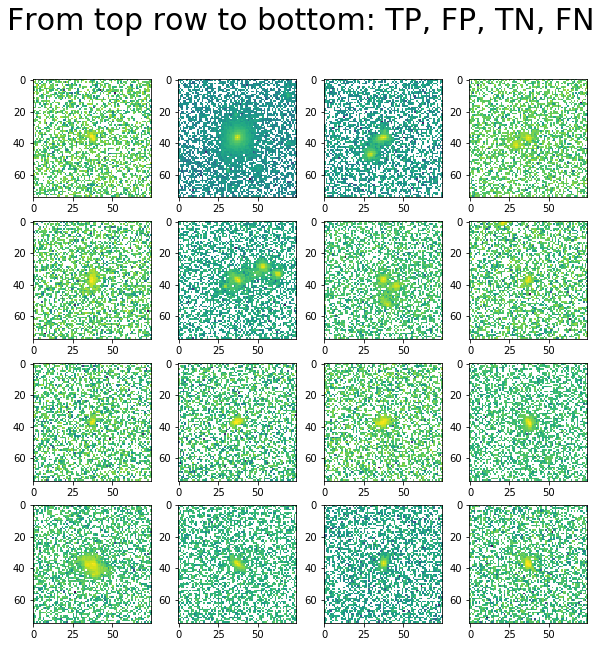

In [37]:
#some example plot from TP,FP,TN and FN
tp1 = x_test[87,1]
tp2 = x_test[1370,1]
tp3 = x_test[2053,1]
tp4 = x_test[3007,1]

fp1 = x_test[538,1]
fp2 = x_test[1216,1]
fp3 = x_test[2900,1]
fp4 = x_test[3021,1]

tn1 = x_test[553,1]
tn2 = x_test[1052,1]
tn3 = x_test[2486,1]
tn4 = x_test[3082,1]

fn1 = x_test[462,1]
fn2 = x_test[1530,1]
fn3 = x_test[2246,1]
fn4 = x_test[3075,1]

examples = [tp1, tp2, tp3, tp4, fp1, fp2, fp3, fp4, tn1, tn2, tn3, tn4, fn1, fn2, fn3, fn4]
figm = plt.figure(figsize=(10,10))

for i in range(0,16):
    figm.suptitle('From top row to bottom: TP, FP, TN, FN', fontsize=30)
    ym = figm.add_subplot(4,4,i+1)
    ym.imshow(examples[i],norm=LogNorm())
    plt.grid(False)
#figm.suptitle('TP', fontsize=30)
plt.show()
figm.savefig('SB25_TP_FP_TN_FN_examples+68.jpg')

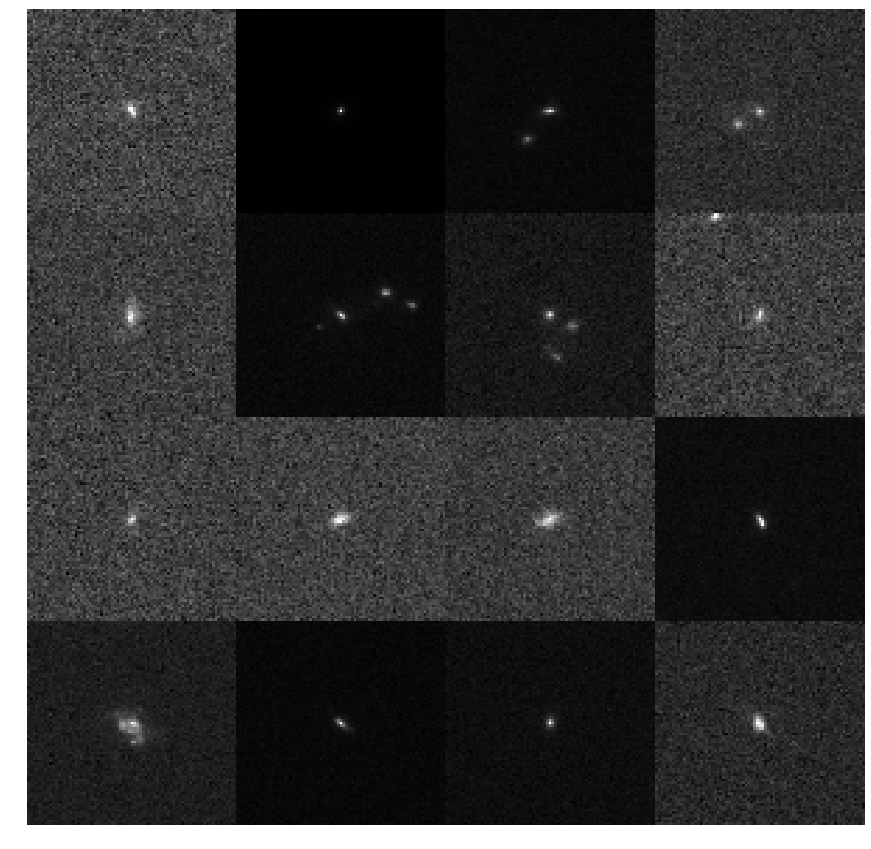

In [39]:
fig1=plt.figure(figsize=(15,15))
for i, image in enumerate(examples):
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    plt.imshow(image, aspect='auto', cmap='gray')#norm=LogNorm()
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig1.savefig('FINAL_SB25_TP_FP_TN_FN_examples_tight_LOG_JET.pdf')

In [76]:
#loading history

import codecs
import os

path = 'model/history_25_68_4.json'
if os.path.exists(path): # reload history if it exists
        with codecs.open(path, 'r', encoding='utf-8') as f:
             n = json.loads(f.read())
                
#LOADING MODEL

json_file = open(f_model, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [8]:
# evaluate loaded model on test data
# load weights into new model
loaded_model.load_weights(f_weights)
print("Loaded model from disk")

loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=True)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
3085/3085 [==============================] - 10s 3ms/step
acc: 72.48%


In [33]:
# load best weights into new model
loaded_model.load_weights(f_best_weights)
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=True)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
3085/3085 [==============================] - 10s 3ms/step
acc: 72.54%


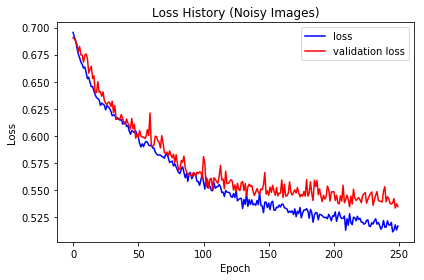

In [40]:
#plotting from history

#LOSS
loss=n['loss']
val_loss=n['val_loss']
epochs = list(range(len(loss)))
#epochs = epochs[:201]
#loss = loss[:201]
#val_loss = val_loss[:201]
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_loss = axis1.plot(epochs, loss, 'b', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'r', label="validation loss")
plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss')
plt.title("Loss History (Noisy Images)")
plt.tight_layout()
axis1.legend(loc='upper right')
#pl.savefig('FINAL_loss_25_68_4.pdf')

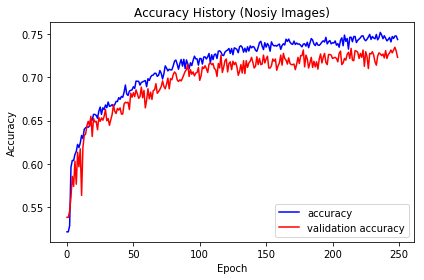

In [13]:
#ACCURACY
acc=n['acc']
val_acc=n['val_acc']
epochs = list(range(len(acc)))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_loss = axis1.plot(epochs, acc, 'b', label='accuracy')
plot1_val_loss = axis1.plot(epochs, val_acc, 'r', label='validation accuracy')
plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Accuracy')
plt.title("Accuracy History (Nosiy Images)")
plt.tight_layout()
axis1.legend(loc='lower right')
#pl.savefig('FINAL_acc_25_68_4.eps')

In [82]:
val_acc.index(max(val_acc))

247

In [87]:
max(val_acc)

0.7347600518806745

In [86]:
val_acc[245:251]

[0.7282749675745784,
 0.7315175097276264,
 0.7347600518806745,
 0.7302204928664072,
 0.7230869001297017]

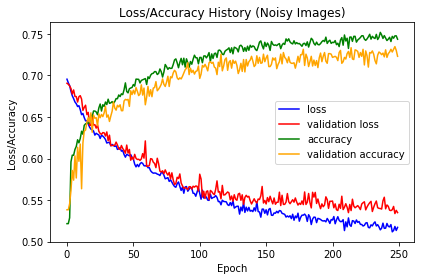

In [75]:
#plotting from history loss and accuracy combined

#LOSS
loss=n['loss']
val_loss=n['val_loss']
acc=n['acc']
val_acc=n['val_acc']

epochs = list(range(len(loss)))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_loss = axis1.plot(epochs, loss, 'b', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'r', label="validation loss")

plot1_lacc = axis1.plot(epochs, acc, 'green', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'orange', label="validation accuracy")

plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History (Noisy Images)")
plt.tight_layout()
axis1.legend(loc='center right')
pl.savefig('FINAL_loss_acc_25_68_4.eps')

cm [[ 983.  444.]
 [ 403. 1255.]]
cm_norm [[0.68885774 0.31114226]
 [0.24306393 0.75693607]]
AUC: 0.8066751593218162


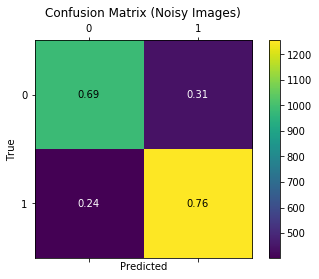

In [34]:
# ------------------------------------------------------------------------------
# Evaluate for TEST SET
# ------------------------------------------------------------------------------
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict
prob = loaded_model.predict(x_test)
pred =  (prob > 0.5).astype('int32') 

# measure confusion
labels=[0, 1]
cm = metrics.confusion_matrix(y_test, pred, labels=labels)
cm = cm.astype('float')
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print("cm", cm)
print("cm_norm", cm_norm)

fpr, tpr, thresholds = metrics.roc_curve(y_test, prob, pos_label=1)
auc = metrics.roc_auc_score(y_test, prob)
print("AUC:", auc)

#plotting

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion Matrix (Noisy Images)',y=1.08)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
fmt = '.2f'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_norm[i, j] < thresh else "black")
pl.savefig('FINAL_Conf_Matrix_SB25_68_TEST_4.pdf')
plt.show()

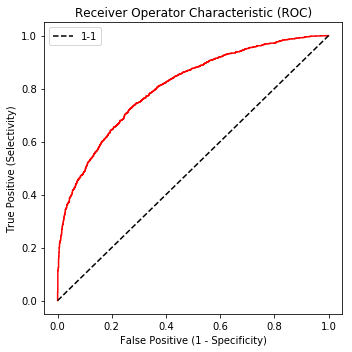

In [17]:
# ROC TEST SET
figsize=(5,5)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]
#label_roc = "ROC, AUC = " + auc if auc is not None else "ROC"
plt.plot(fpr, tpr, 'r-')#,  label=label_roc)
plt.plot(x_onetoone, y_onetoone, 'k--',  label="1-1")
plt.legend(loc=0)
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False Positive (1 - Specificity)")
plt.ylabel("True Positive (Selectivity)")
plt.tight_layout()
pl.savefig('FINAL_ROC_SB25_68_TEST_bestweights_4.pdf')

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, pred)
print('F1 score: %f' % f1)

Accuracy: 0.725446
Precision: 0.738670
Recall: 0.756936
F1 score: 0.747691


In [ ]:
# plots with subsamlpes

In [19]:
#make subsamples for plotting
list_pre = []
list_post = []
list_nonmerger = []



for i in range(len(y_sub_test)):
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==1:
        list_pre.append(prob[i])
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==0:
        list_post.append(prob[i])
    if y_sub_test[i,0]==0:
        list_nonmerger.append(prob[i])
pre = np.stack(list_pre)
post = np.stack(list_post)
non = np.stack(list_nonmerger)

In [54]:
print('pre:',len(pre) ,'post:',len(post),'\n summ:',len(pre)+len(post))
print('nonmergers:',len(non))

pre: 1272 post: 386 
 summ: 1658
nonmergers: 1427


In [55]:
np.count_nonzero(y_sub_test[:,0])

1658

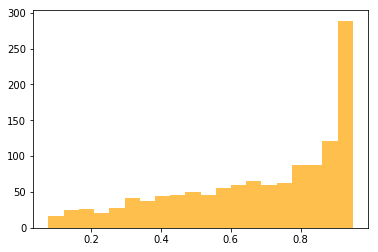

In [20]:
x1 = pre
num_bins = 20
n, bins, patches = plt.hist(x1, num_bins, facecolor='orange', alpha=0.7)
plt.show()

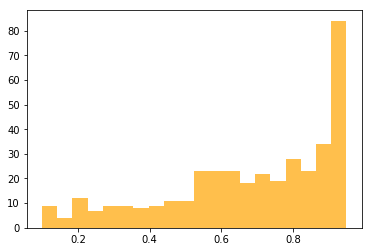

In [21]:
x2 = post
num_bins = 20
n, bins, patches = plt.hist(x2, num_bins, facecolor='orange', alpha=0.7)
plt.show()

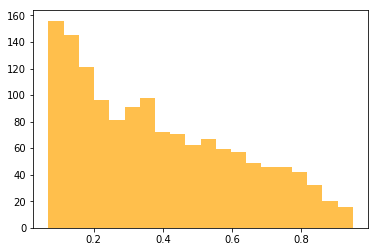

In [22]:
x3 = non
num_bins = 20
n, bins, patches = plt.hist(x3, num_bins, facecolor='orange', alpha=0.7)
plt.show()

Number of pre-mergers: 1272 
Number of post-mergers: 386 
Number of nonmergers: 1427 

TEST SET OF NOISY IMAGES SB25


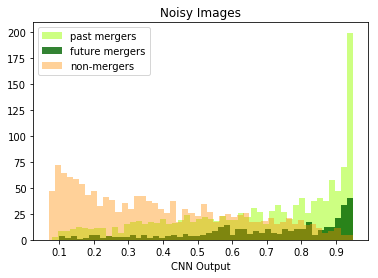

In [24]:
print('Number of pre-mergers:',len(pre) ,'\nNumber of post-mergers:',len(post),'\nNumber of nonmergers:',len(non),'\n\nTEST SET OF NOISY IMAGES SB25')
bins = 50
plt.hist(x1, bins, alpha=0.6, label='past mergers', color='greenyellow')
plt.hist(x2, bins, alpha=0.8, label='future mergers', color='darkgreen')
plt.hist(x3, bins, alpha=0.4, label='non-mergers', color='darkorange')
plt.legend(loc='upper left')#,bbox_to_anchor=(0.9, 1))
plt.xticks(np.arange(0.1, 1, step=0.1))
plt.title("Noisy Images")
plt.xlabel("CNN Output")
plt.savefig('FINAL_Histogram_SB25_68_4.pdf')
plt.show()

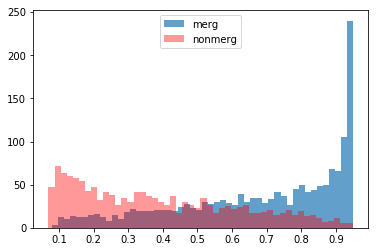

In [63]:
merg = np.concatenate((pre, post))
bins = 50
plt.hist(merg, bins, alpha=0.7, label='merg')
plt.hist(x3, bins, alpha=0.4, label='nonmerg', color='red')
plt.xticks(np.arange(0.1, 1, step=0.1))
plt.legend(loc='upper center')
plt.savefig('Histogram_SB25_68_4.jpg')
plt.show()

In [ ]:
#morphology study

In [25]:
#make subsamples for plotting
list_pre_subid = []
list_post_subid = []
list_nonmerger_subid = []


cc_pre_list = []
cc_post_list = []
cc_non_list = []

m20_pre_list = []
m20_post_list = []
m20_non_list = []


for i in range(len(y_sub_test)):
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==1:
        list_pre_subid.append(subid_test[i])
        cc_pre_list.append(cc_test[i])
        m20_pre_list.append(m20_test[i])
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==0:
        list_post_subid.append(subid_test[i])
        cc_post_list.append(cc_test[i])
        m20_post_list.append(m20_test[i])
    if y_sub_test[i,0]==0:
        list_nonmerger_subid.append(subid_test[i])
        cc_non_list.append(cc_test[i])
        m20_non_list.append(m20_test[i])
        
pre_subid = np.stack(list_pre_subid)
post_subid = np.stack(list_post_subid)
non_subid = np.stack(list_nonmerger_subid)

cc_pre = np.stack(cc_pre_list)
cc_post = np.stack(cc_post_list)
cc_non = np.stack(cc_non_list)

m20_pre = np.stack(m20_pre_list)
m20_post = np.stack(m20_post_list)
m20_non = np.stack(m20_non_list)

In [65]:
print('pre:',len(pre_subid),'post:',len(post_subid),'\n summ:',len(pre_subid)+len(post_subid))
print('nonmergers:',len(non_subid))

pre: 1272 post: 386 
 summ: 1658
nonmergers: 1427


In [66]:
print('pre:',len(cc_pre),'post:',len(cc_post),'\n summ:',len(cc_pre)+len(cc_post))
print('nonmergers:',len(cc_non),'\n')

print('pre:',len(cc_pre),'post:',len(cc_post),'\n summ:',len(cc_pre)+len(cc_post))
print('nonmergers:',len(cc_non))

pre: 1272 post: 386 
 summ: 1658
nonmergers: 1427 

pre: 1272 post: 386 
 summ: 1658
nonmergers: 1427


In [58]:
np.save('past_mergers_subid.npy',pre_subid)
np.save('future_mergers_subid.npy',post_subid)
np.save('nonmergers_subid.npy',non_subid)

In [76]:
np.where(pre_subid == 102955)[0]

array([ 16,  37, 275, 475])

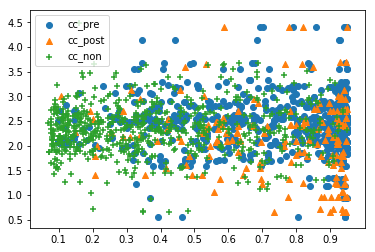

In [26]:
plt.scatter(pre, cc_pre,marker='o',label='cc_pre')
plt.scatter(post, cc_post,marker='^',label='cc_post')
plt.scatter(non, cc_non,marker='+',label='cc_non')
plt.xticks(np.arange(0.1, 1, step=0.1))
plt.legend(loc='upper left')
plt.show()

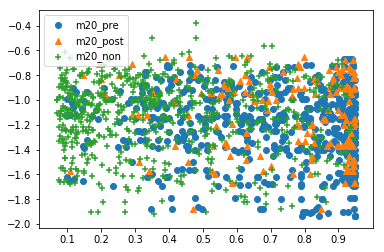

In [27]:
plt.scatter(pre, m20_pre,marker='o', label='m20_pre')
plt.scatter(post, m20_post,marker='^',label='m20_post')
plt.scatter(non, m20_non,marker='+',label='m20_non')
plt.xticks(np.arange(0.1, 1, step=0.1))
plt.legend(loc='upper left')
plt.show()

/home/aleksandra/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/aleksandra/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


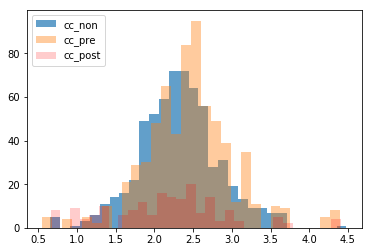

In [69]:
bins = 30
plt.hist(cc_non, bins, alpha=0.7, label='cc_non')
plt.hist(cc_pre, bins, alpha=0.4, label='cc_pre')
plt.hist(cc_post, bins, alpha=0.2, label='cc_post', color='red')
plt.legend(loc='upper left')
#plt.savefig('Histogram_SB25_68.jpg')
plt.show()

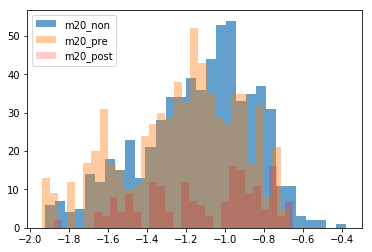

In [70]:
bins = 30
plt.hist(m20_non, bins, alpha=0.7, label='m20_non')
plt.hist(m20_pre, bins, alpha=0.4, label='m20_pre')
plt.hist(m20_post, bins, alpha=0.2, label='m20_post', color='red')
plt.legend(loc='upper left')
#plt.savefig('Histogram_SB25_68.jpg')
plt.show()

In [ ]:
#lets import SB00 model and try to clasisfy nosiy images with it

In [88]:
f_model = dir_test + "SB00_model_68_4.json" # model data (architecture)
f_weights = dir_test + "SB00_weights_68_4.h5" # model data (weights that we fit for)
f_history = dir_test + "SB00_history_68_4.json"
f_best_weights = dir_test + "SB0_best_weights_68_4.h5"

In [89]:
#LOADING MODEL


json_file = open(f_model, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load best weights into new model
loaded_model.load_weights(f_best_weights)
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=True)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
3085/3085 [==============================] - 11s 4ms/step
acc: 47.55%


cm [[1415.   12.]
 [1606.   52.]]
cm_norm [[0.99159075 0.00840925]
 [0.96863691 0.03136309]]
AUC: 0.5651856366490473


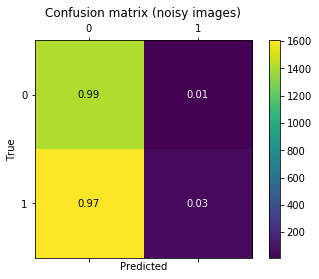

In [90]:
# ------------------------------------------------------------------------------
# Evaluate for TEST SET
# ------------------------------------------------------------------------------
# predict
prob = loaded_model.predict(x_test)
pred =  (prob > 0.5).astype('int32') 

# measure confusion
labels=[0, 1]
cm = metrics.confusion_matrix(y_test, pred, labels=labels)
cm = cm.astype('float')
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print("cm", cm)
print("cm_norm", cm_norm)

fpr, tpr, thresholds = metrics.roc_curve(y_test, prob, pos_label=1)
auc = metrics.roc_auc_score(y_test, prob)
print("AUC:", auc)

#plotting

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix (noisy images)',y=1.08)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
fmt = '.2f'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_norm[i, j] < thresh else "black")
#pl.savefig('Conf_Matrix_SB25_C6_TEST.jpg')
plt.show()

In [91]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, pred)
print('F1 score: %f' % f1)

Accuracy: 0.475527
Precision: 0.812500
Recall: 0.031363
F1 score: 0.060395


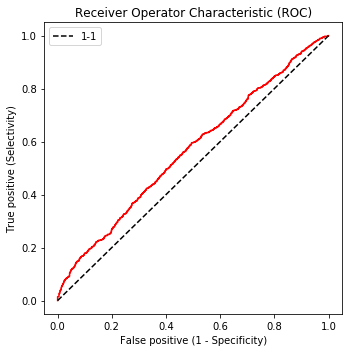

In [92]:
# ROC TEST SET
figsize=(5,5)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]
#label_roc = "ROC, AUC = " + auc if auc is not None else "ROC"
plt.plot(fpr, tpr, 'r-')#,  label=label_roc)
plt.plot(x_onetoone, y_onetoone, 'k--',  label="1-1")
plt.legend(loc=0)
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False positive (1 - Specificity)")
plt.ylabel("True positive (Selectivity)")
plt.tight_layout()
#pl.savefig('ROC_SB25_C68_TEST_bestweights.pdf')